In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e .
!pip install -e .[notebooks]

Cloning into 'sam3'...
remote: Enumerating objects: 578, done.
remote: Total 578 (delta 0), reused 0 (delta 0), pack-reused 578 (from 1)
Receiving objects: 100% (578/578), 58.92 MiB | 12.43 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 102.9 MB/s eta 0:00:00
  Building editable for sam3 (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-0.editable-py3-none-any.whl size=15197 sha256=

Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.2/143.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.8/515.8 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB

In [1]:
import sys
sys.path.append('/content/sam3')

In [10]:
import torch
#################################### For Image ####################################
from PIL import Image
import sam3
from sam3 import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor
# Load the model
model = build_sam3_image_model()
processor = Sam3Processor(model)
# Load an image



FileNotFoundError: [Errno 2] No such file or directory: 'images/image7.jpg'

In [13]:
image = Image.open("images/image8.jpg")
inference_state = processor.set_image(image)
# Prompt the model with text
output = processor.set_text_prompt(state=inference_state, prompt="humans")
# Get the masks, bounding boxes, and scores
masks, boxes, scores = output["masks"], output["boxes"], output["scores"]

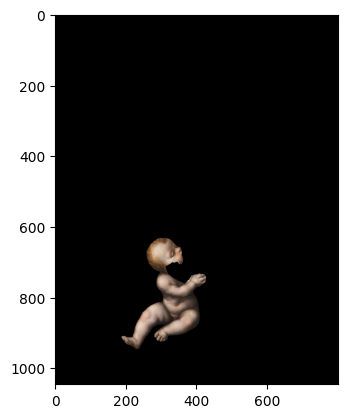

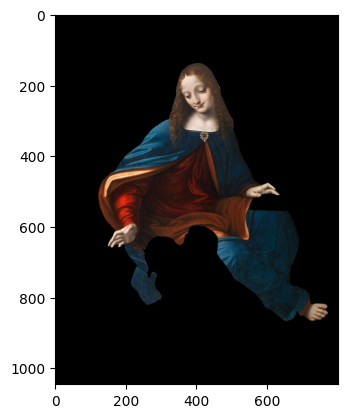

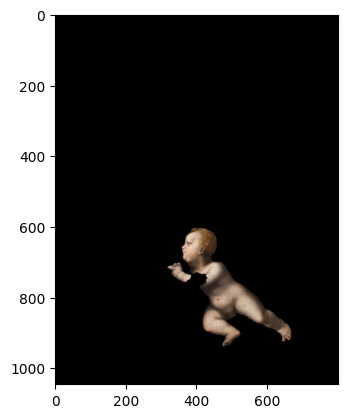

In [14]:
import numpy as np
import matplotlib.pyplot as plt
l = []
for mask in masks.cpu().numpy():
  label3 = np.stack([mask[0],mask[0],mask[0]], axis=2)
  l.append(image * label3)
for i in l:
  plt.imshow(i)
  plt.show()
